In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from deeper.deeper_utils import wrap_deeper
import pandas as pd
import numpy as np
from erexplain import explainSamples
import os,contextlib,random,string
import deepmatcher as dm
from keras.models import load_model
from deeper.DeepER import init_embeddings_model

Using TensorFlow backend.


## Prelimary operations

In [7]:
def wrapDm(test_df,model,ignore_columns=['label'],outputAttributes=False,batch_size=32):
    data = test_df.copy().drop([c for c in ignore_columns if c in test_df.columns],axis=1)
    if not('id' in data.columns):
        data['id'] = np.arange(len(data))
    tmp_name = "./{}.csv".format("".join([random.choice(string.ascii_lowercase) for _ in range(10)]))
    data.to_csv(tmp_name,index=False)
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull):
            data_processed = dm.data.process_unlabeled(tmp_name, trained_model = model)
            predictions = model.run_prediction(data_processed, output_attributes = outputAttributes,\
                                              batch_size=batch_size)
            out_proba = predictions['match_score'].values
    multi_proba = np.dstack((1-out_proba, out_proba)).squeeze()
    os.remove(tmp_name)
    if outputAttributes:
        return predictions
    else:
        return multi_proba

In [8]:
# Caricamento strutture dati e modelli ausiliari.
EMBEDDING_FILEPATH ='embeddings/glove.840B.300d.txt'
embeddings_model, tokenizer = init_embeddings_model(EMBEDDING_FILEPATH)

* Costruzione indice degli embeddings.....Fatto. 2196016 embeddings totali.
* Inizializzo il tokenizzatore.....Fatto: 1131743 parole totali.
* Preparazione della matrice di embedding.....Fatto. Dimensioni matrice embeddings: (1131744, 300)

°°° EMBEDDING MODEL °°°
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tupla_A (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
Tupla_B (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
Embedding_lookup (Embedding)    (None, None, 300)    339523200   Tupla_A[0][0]                    
                         

In [9]:
predict_fn_deeper = lambda data,model,ignore: wrap_deeper(data,'ltable_','rtable_',model,tokenizer,embeddings_model,
                                                  ignore_columns=ignore)

In [10]:
predict_fn_deepmatcher = lambda data,model,ignore: wrapDm(data,model,ignore_columns=ignore)

In [11]:
def formatId(sampleid):
    leftid = sampleid.split("#")[0]
    rightid = sampleid.split("#")[1]
    return "0@"+leftid+"#"+"1@"+rightid

In [12]:
def getCorrectPredictions(df,model,predict_fn):
    predictions = np.argmax(predict_fn(df,model,['label','id']),axis=1)
    return df[predictions==df.label.values]

In [13]:
def saveExplanationResult(directory2save,model_type,dataset_name,posrank,negrank,flippedpos,flippedneg):
    if not(os.path.exists(os.path.join(directory2save,model_type,dataset_name))):
        saving_directory = (os.path.join(directory2save,model_type,dataset_name))
        os.mkdir(saving_directory)
    else:
        saving_directory = (os.path.join(directory2save,model_type,dataset_name))
    posrank.to_csv(os.path.join(saving_directory,'pos_rankings.csv'))
    negrank.to_csv(os.path.join(saving_directory,'neg_rankings.csv'))
    flippedneg.to_csv(os.path.join(saving_directory,'flipped_neg.csv'),index=False)
    flippedpos.to_csv(os.path.join(saving_directory,'flipped_pos.csv'),index=False)

## BeerAdvo-Ratebeer

In [13]:
augmented_test = pd.read_csv('datasets/beeradvo_ratebeer/augmented_test.csv')
beeradvo = pd.read_csv('datasets/beeradvo_ratebeer/Beeradvo.csv',dtype=str)
ratebeer = pd.read_csv('datasets/beeradvo_ratebeer/Ratebeer.csv',dtype=str)

In [14]:
augmented_test['id'] = augmented_test['id'].apply(lambda sampleid:formatId(sampleid))

In [15]:
beer_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
beer_deepmatcher.load_state('models/beeradvo_ratebeer_rnn.pth')
beer_deeper = load_model('models/DeepER_best_model_100_beeradvo-ratebeer.h5')

In [25]:
correct_preds_deeper = getCorrectPredictions(augmented_test,beer_deeper,predict_fn_deeper)

In [26]:
negrank_deeper,flippedneg_deeper = explainSamples(correct_preds_deeper,[beeradvo,ratebeer],beer_deeper,predict_fn_deeper,
                                 0,3)

100%|██████████| 20/20 [00:00<00:00, 43.37it/s]


In [32]:
posrank_deeper,flippedpos_deeper = explainSamples(correct_preds_deeper,[beeradvo,ratebeer],beer_deeper,predict_fn_deeper,
                                 1,3)

100%|██████████| 20/20 [00:00<00:00, 40.63it/s]


In [28]:
correct_preds_deepmatcher = getCorrectPredictions(augmented_test,beer_deepmatcher,predict_fn_deepmatcher)

In [29]:
negrank_deepmatcher,flippedneg_deepmatcher = explainSamples(correct_preds_deepmatcher,[beeradvo,ratebeer],
                                                            beer_deepmatcher,predict_fn_deepmatcher,0,3)

100%|██████████| 31/31 [00:03<00:00,  9.62it/s]


In [30]:
posrank_deepmatcher,flippedpos_deepmatcher = explainSamples(correct_preds_deepmatcher,[beeradvo,ratebeer],beer_deepmatcher,
                                                           predict_fn_deepmatcher,1,3)

100%|██████████| 31/31 [00:03<00:00,  8.70it/s]


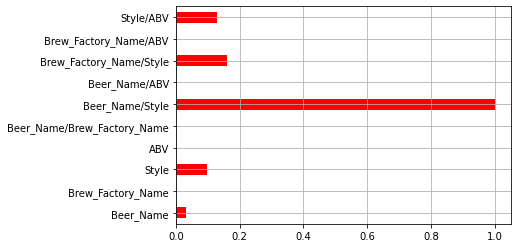

In [21]:
negrank_deepmatcher[0:10].plot.barh(color='red',grid=True)

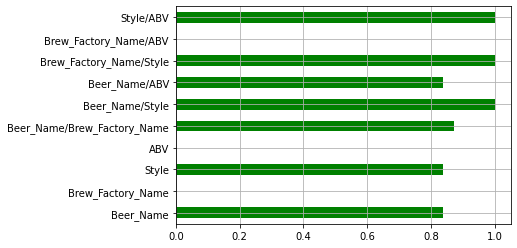

In [22]:
posrank_deepmatcher[0:10].plot.barh(color='green',grid=True)

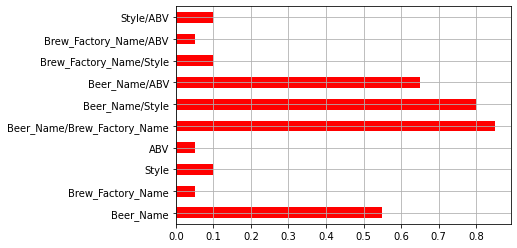

In [34]:
negrank_deeper[0:10].plot.barh(color='red',grid=True)

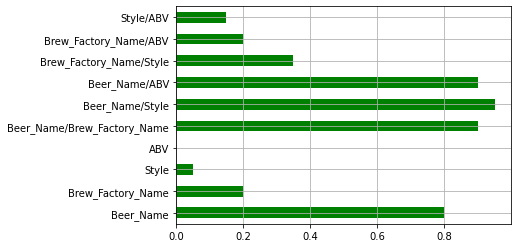

In [33]:
posrank_deeper[0:10].plot.barh(color='green',grid=True)

In [38]:
posrank_deepmatcher.to_csv('rankings/deepmatcher/beer_pos_rankings.csv')
negrank_deepmatcher.to_csv('rankings/deepmatcher/beer_neg_rankings.csv')
posrank_deeper.to_csv('rankings/deeper/beer_pos_rankings.csv')
negrank_deeper.to_csv('rankings/deeper/beer_neg_rankings.csv')

In [35]:
flippedneg_deeper.to_csv('rankings/deeper/beer_flippedneg_deeper.csv',index=False)
flippedneg_deepmatcher.to_csv('rankings/deeper/beer_flippedneg_deepmatcher.csv',index=False)
flippedpos_deeper.to_csv('rankings/beer_flippepos_deeper.csv',index=False)
flippedpos_deepmatcher.to_csv('rankings/beer_flippedpos_deepmatcher.csv',index=False)

## Walmart-Amazon

In [10]:
augmented_test = pd.read_csv('datasets/walmart_amazon/augmented_test.csv')
walmart = pd.read_csv('datasets/walmart_amazon/walmart.csv',dtype=str)
amazon = pd.read_csv('datasets/walmart_amazon/amazon.csv',dtype=str)

In [12]:
augmented_test['id'] = augmented_test['id'].apply(lambda sampleid:formatId(sampleid))

In [13]:
walmart_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
walmart_deepmatcher.load_state('models/walmart_amazon_rnn.pth')
walmart_deeper = load_model('models/DeepER_best_model_100_walmart-amazon.h5')

In [16]:
corrects_deepmatcher = getCorrectPredictions(augmented_test,walmart_deepmatcher,predict_fn_deepmatcher)

In [22]:
corrects_deeper = getCorrectPredictions(augmented_test,walmart_deeper,predict_fn_deeper)

In [19]:
negrank_deeper,flippedneg_deeper = explainSamples(corrects_deeper,[walmart,amazon],walmart_deeper,predict_fn_deeper,0,4)


 59%|█████▉    | 309/522 [00:51<00:35,  6.05it/s]


100%|██████████| 522/522 [01:27<00:00,  5.97it/s]


In [20]:
negrank_deepmatcher,flippedneg_deepmatcher = explainSamples(corrects_deepmatcher,[walmart,amazon],walmart_deepmatcher,
                             predict_fn_deepmatcher,0,4)


 57%|█████▋    | 309/541 [03:31<02:34,  1.50it/s]


100%|██████████| 541/541 [06:10<00:00,  1.46it/s]


In [23]:
posrank_deeper,flippedpos_deeper = explainSamples(corrects_deeper,[walmart,amazon],walmart_deeper,predict_fn_deeper,
                             1,4)


 59%|█████▉    | 309/522 [00:51<00:35,  6.04it/s]


100%|██████████| 522/522 [01:27<00:00,  5.97it/s]


In [24]:
posrank_deepmatcher,flippedpos_deepmatcher = explainSamples(corrects_deepmatcher,[walmart,amazon],walmart_deepmatcher,
                                         predict_fn_deepmatcher,1,4)


 57%|█████▋    | 309/541 [03:28<02:55,  1.32it/s]


100%|██████████| 541/541 [06:04<00:00,  1.48it/s]


In [26]:
saveExplanationResult('rankings/','deepmatcher','walmart_amazon',posrank=posrank_deepmatcher,negrank=negrank_deepmatcher,
                     flippedneg=flippedneg_deepmatcher,flippedpos=flippedpos_deepmatcher)

In [27]:
saveExplanationResult('rankings/','deeper','walmart_amazon',posrank_deeper,negrank_deeper,flippedpos_deeper,
                     flippedneg_deeper)

## Amazon-Google

In [28]:
augmented_test = pd.read_csv('datasets/Amazon-GoogleProducts/augmented_test.csv')
amazon = pd.read_csv('datasets/Amazon-GoogleProducts/Amazon.csv',dtype=str)
google = pd.read_csv('datasets/Amazon-GoogleProducts/Google.csv',dtype=str)

In [29]:
augmented_test['id'] = augmented_test['id'].apply(lambda sampleid:formatId(sampleid))

In [30]:
amzgoogle_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
amzgoogle_deepmatcher.load_state('models/amazon_google_rnn.pth')
amzgoogle_deeper = load_model('models/DeepER_best_model_100_amazon-google.h5')

In [35]:
corrects_deeper = getCorrectPredictions(augmented_test,amzgoogle_deeper,predict_fn_deeper)

In [37]:
corrects_deepmatcher = getCorrectPredictions(augmented_test,amzgoogle_deepmatcher,predict_fn_deepmatcher)

In [36]:
negrank_deeper,flippedneg_deeper = explainSamples(corrects_deeper,[amazon,google],amzgoogle_deeper,
                                  predict_fn_deeper,0,3)


100%|██████████| 183/183 [00:21<00:00,  8.52it/s]


In [38]:
negrank_deepmatcher,flippedneg_deepmatcher = explainSamples(corrects_deepmatcher,[amazon,google],amzgoogle_deepmatcher
                                         ,predict_fn_deepmatcher,0,3)


100%|██████████| 303/303 [03:01<00:00,  1.67it/s]


In [39]:
posrank_deeper,flippedpos_deeper = explainSamples(corrects_deeper,[amazon,google],amzgoogle_deeper,predict_fn_deeper,1,3)


100%|██████████| 183/183 [00:21<00:00,  8.71it/s]


In [40]:
posrank_deepmatcher,flippedpos_deepmatcher = explainSamples(corrects_deepmatcher,[amazon,google],amzgoogle_deepmatcher,
                                         predict_fn_deepmatcher,1,3)


100%|██████████| 303/303 [03:02<00:00,  1.66it/s]


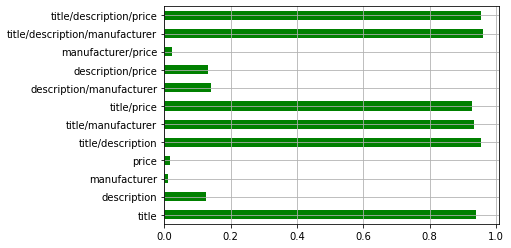

In [45]:
posrank_deeper[0:12].plot.barh(color='green',grid=True)

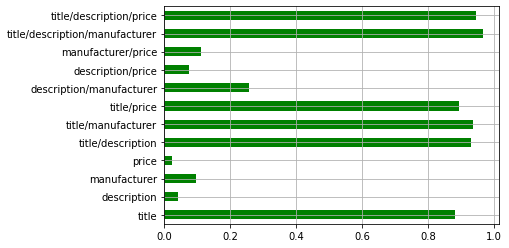

In [44]:
posrank_deepmatcher[0:12].plot.barh(color='green',grid=True)

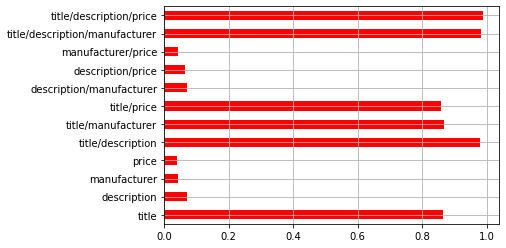

In [43]:
negrank_deeper[0:12].plot.barh(color='red',grid=True)

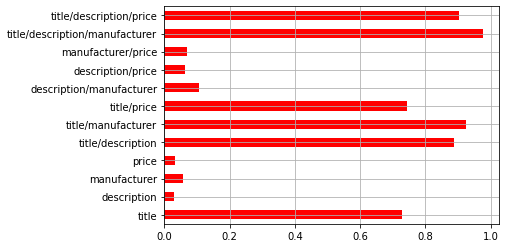

In [46]:
negrank_deepmatcher[0:12].plot.barh(color='red',grid=True)

In [47]:
saveExplanationResult('rankings/','deeper','amazon_google',posrank=posrank_deeper,negrank=negrank_deeper,
                     flippedneg=flippedneg_deeper,flippedpos=flippedpos_deeper)

In [48]:
saveExplanationResult('rankings/','deepmatcher','amazon_google',posrank_deepmatcher,negrank_deepmatcher,
                     flippedpos_deepmatcher,flippedneg_deepmatcher)

## DBLP-ACM

In [49]:
augmented_test = pd.read_csv('datasets/DBLP-ACM/augmented_test.csv')
dblp = pd.read_csv('datasets/DBLP-ACM/DBLP2.csv',dtype=str)
acm = pd.read_csv('datasets/DBLP-ACM/ACM.csv',dtype=str)

In [50]:
augmented_test['id'] = augmented_test['id'].apply(lambda sampleid:formatId(sampleid))

In [52]:
dblpacm_deeper = load_model('models/DeepER_best_model_100_dblp-acm.h5')
dblpacm_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
dblpacm_deepmatcher.load_state('models/dblp_acm_rnn.pth')

In [53]:
corrects_deeper = getCorrectPredictions(augmented_test,dblpacm_deeper,predict_fn_deeper)

In [54]:
corrects_deepmatcher = getCorrectPredictions(augmented_test,dblpacm_deepmatcher,predict_fn_deepmatcher)

In [59]:
negrank_deeper,flippedneg_deeper = explainSamples(corrects_deeper,[dblp,acm],dblpacm_deeper,predict_fn_deeper,
                                   0,3)


100%|██████████| 604/604 [00:12<00:00, 48.72it/s]


In [60]:
negrank_deepmatcher,flippedneg_deepmatcher = explainSamples(corrects_deepmatcher,[dblp,acm],dblpacm_deepmatcher,predict_fn_deepmatcher,
                                        0,3)


 49%|████▉     | 309/631 [01:05<01:07,  4.78it/s]


 98%|█████████▊| 617/631 [02:18<00:02,  4.85it/s]


100%|██████████| 631/631 [02:21<00:00,  4.47it/s]


In [61]:
posrank_deeper,flippedpos_deeper = explainSamples(corrects_deeper,[dblp,acm],dblpacm_deeper,predict_fn_deeper,
                                   1,3)


100%|██████████| 604/604 [00:12<00:00, 47.36it/s]


In [62]:
posrank_deepmatcher,flippedpos_deepmatcher = explainSamples(corrects_deepmatcher,[dblp,acm],dblpacm_deepmatcher,predict_fn_deepmatcher,
                                        1,3)


 49%|████▉     | 309/631 [01:17<01:21,  3.97it/s]


 98%|█████████▊| 617/631 [02:31<00:04,  3.24it/s]


100%|██████████| 631/631 [02:35<00:00,  4.05it/s]


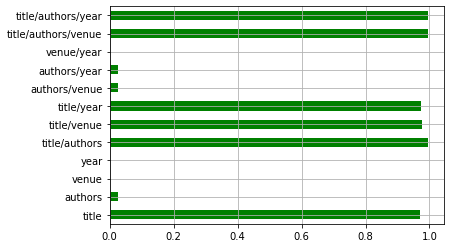

In [64]:
posrank_deeper[0:12].plot.barh(color='green',grid=True)

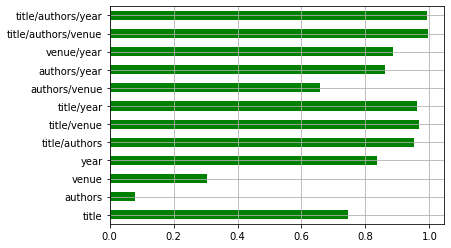

In [65]:
posrank_deepmatcher[0:12].plot.barh(color='green',grid=True)

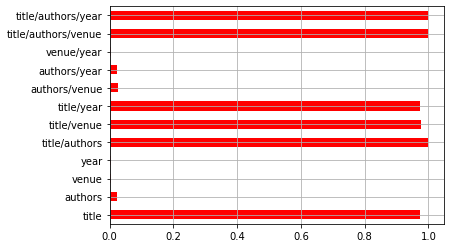

In [63]:
negrank_deeper[0:12].plot.barh(color='red',grid=True)

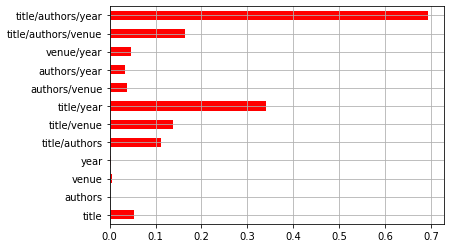

In [66]:
negrank_deepmatcher[0:12].plot.barh(color='red',grid=True)

In [72]:
saveExplanationResult('rankings/','deeper','dblp_acm',posrank_deeper,negrank_deeper,flippedpos_deeper,
                     flippedneg_deeper)

In [70]:
saveExplanationResult('rankings/','deepmatcher','dblp_acm',posrank_deepmatcher,negrank_deepmatcher,flippedpos_deepmatcher,
                     flippedneg_deepmatcher)

## DBLP- Scholar

In [ ]:
augmented_test = pd.read_csv('datasets/DBLP-Scholar/augmented_test.csv')
dblp = pd.read_csv('datasets/DBLP-Scholar/DBLP.csv',dtype=str)
scholar = pd.read_csv('datasets/DBLP-Scholar/Scholar.csv',dtype=str)

In [ ]:
dblpscholar_deeper = load_model('models/DeepER_best_model_100_DBLP_Scholar.h5')
dblpscholar_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
dblpscholar_deepmatcher.load_state('models/dblp_scholar_rnn.pth')

In [ ]:
negrank_deeper,_ = explainSamples(augmented_test,[dblp,scholar],dblpscholar_deeper,predict_fn_deeper,
                                   0,1)

In [ ]:
posrank_deeper,_ = explainSamples(augmented_test,[dblp,scholar],dblpscholar_deeper,predict_fn_deeper,
                                 1,1)

In [ ]:
negrank_deepmatcher,_ = explainSamples(augmented_test,[dblp,scholar],dblpscholar_deepmatcher,predict_fn_deepmatcher,
                                      0,1)

In [ ]:
posrank_deepmatcher,_ = explainSamples(augmented_test,[dblp,scholar],dblpscholar_deepmatcher,predict_fn_deepmatcher,
                                      1,1)

In [ ]:
negrank_deeper.plot.bar(color='red',ylim=(0,1))

In [ ]:
negrank_deepmatcher.plot.bar(color='red',ylim=(0,1))

In [ ]:
posrank_deeper.plot.bar(color='green',ylim=(0,1))

In [ ]:
posrank_deepmatcher.plot.bar(color='green',ylim=(0,1))

In [ ]:
posrank_deepmatcher.to_csv('posrank_deepmatcher_dblpacm.csv')
posrank_deeper.to_csv('posrank_deeper_dblpacm.csv')
negrank_deepmatcher.to_csv('negrank_deepmatcher_dblpacm.csv')
negrank_deeper.to_csv('negrank_deeper_dblpacm.csv')

## Fodors-Zagats

In [ ]:
augmented_test = pd.read_csv('datasets/fodors_zagats/augmented_test.csv')
fodors = pd.read_csv('datasets/fodors_zagats/fodors.csv',dtype=str)
zagats = pd.read_csv('datasets/fodors_zagats/zagats.csv',dtype=str)

In [ ]:
##fodors_deeper = load_model('models/DeepER_best_model_100_fodors-zagats.h5')
fodors_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
fodors_deepmatcher.load_state('models/fodors_zagats_rnn.pth')

In [ ]:
negrank_deeper,_ = explainSamples(correct_deeper,[fodors,zagats],fodors_deeper,predict_fn_deeper,
                                   0,1)

In [ ]:
negrank_deepmatcher,_ = explainSamples(augmented_test,[fodors,zagats],fodors_deepmatcher,predict_fn_deepmatcher,
                                        0,1)

In [ ]:
negrank_deepmatcher.plot.barh(color='red')

In [ ]:
ax,negrank = aggregateRankings(negrank_deeper,positive=False,maxLenAttributes=1,lenTriangles=8)

In [ ]:
posrank_deepmatcher,_ = explainSamples(augmented_test,[fodors,zagats],fodors_deepmatcher,predict_fn_deepmatcher,
                                        1,1)

In [ ]:
posrank_deepmatcher.plot.barh(color='green')

In [ ]:
posrank_deeper,_,_ = explainSamples(correct_deeper,[fodors,zagats],fodors_deeper,predict_fn_deeper,
                                   1,1)

In [ ]:
ax,posrank = aggregateRankings(posrank_deepmatcher,positive=True,maxLenAttributes=1,lenTriangles=50)

In [ ]:
ax,posrank = aggregateRankings(posrank_deeper,positive=True,maxLenAttributes=1,lenTriangles=8)

## Itunes-Amazon

In [73]:
DATASET_DIR = 'datasets/itunes_amazon/'

In [74]:
augmented_test = pd.read_csv(DATASET_DIR+'augmented_test.csv')
itunes = pd.read_csv(DATASET_DIR+'itunes.csv',dtype=str)
amazon = pd.read_csv(DATASET_DIR+'amazon.csv',dtype=str)

In [75]:
augmented_test['id'] = augmented_test['id'].apply(lambda sampleid:formatId(sampleid))

In [77]:
itunes_deeper = load_model('models/DeepER_best_model_100_itunes-amazon.h5')
itunes_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
itunes_deepmatcher.load_state('models/itunes_amazon_rnn.pth')

In [78]:
corrects_deeper = getCorrectPredictions(augmented_test,itunes_deeper,predict_fn_deeper)

In [79]:
corrects_deepmatcher = getCorrectPredictions(augmented_test,itunes_deepmatcher,predict_fn_deepmatcher)

In [80]:
negrank_deeper,flippedneg_deeper = explainSamples(corrects_deeper,[itunes,amazon],itunes_deeper,predict_fn_deeper,
                                   0,4)


100%|██████████| 63/63 [00:17<00:00,  3.69it/s]


In [81]:
negrank_deepmatcher,flippedneg_deepmatcher = explainSamples(corrects_deepmatcher,[itunes,amazon],itunes_deepmatcher,
                                         predict_fn_deepmatcher,0,4)


100%|██████████| 75/75 [01:16<00:00,  1.02s/it]


In [82]:
posrank_deeper,flippedpos_deeper = explainSamples(corrects_deeper,[itunes,amazon],itunes_deeper,predict_fn_deeper,
                                   1,4)


100%|██████████| 63/63 [00:16<00:00,  3.87it/s]


In [83]:
posrank_deepmatcher,flippedpos_deepmatcher = explainSamples(corrects_deepmatcher,[itunes,amazon],itunes_deepmatcher,predict_fn_deepmatcher,
                                        1,4)


100%|██████████| 75/75 [01:17<00:00,  1.03s/it]


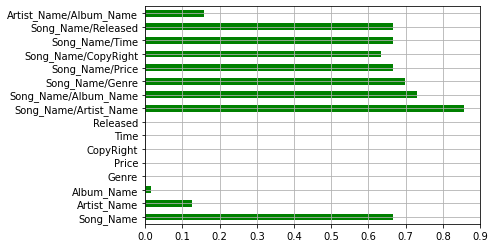

In [85]:
posrank_deeper[0:16].plot.barh(color='green',grid=True)

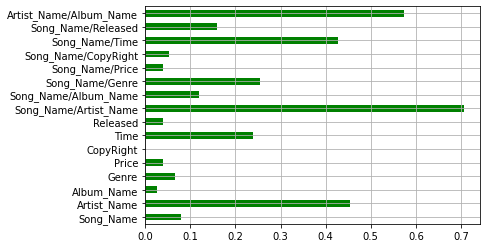

In [86]:
posrank_deepmatcher[0:16].plot.barh(color='green',grid=True)

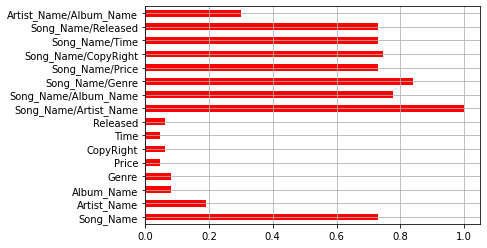

In [87]:
negrank_deeper[0:16].plot.barh(color='red',grid=True)

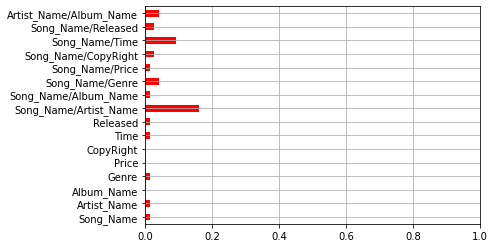

In [89]:
negrank_deepmatcher[0:16].plot.barh(color='red',grid=True,xlim=(0,1))

In [90]:
saveExplanationResult('rankings/','deeper','itunes_amazon',posrank_deeper,negrank_deeper,flippedpos_deeper,
                     flippedneg_deeper)

In [91]:
saveExplanationResult('rankings/','deepmatcher','itunes_amazon',posrank_deepmatcher,negrank_deepmatcher,
                      flippedpos_deepmatcher,flippedneg_deepmatcher)

## Geographical settlements

In [14]:
DATASET_DIR = 'datasets/GeographicSettlements/'

In [16]:
augmented_test = pd.read_csv(DATASET_DIR+'test.csv')
lsource = pd.read_csv(DATASET_DIR+'settlements_reduced.csv',dtype=str)
rsource = pd.read_csv(DATASET_DIR+'settlements_reduced.csv',dtype=str)

In [18]:
geography_deeper = load_model('models/DeepER_best_model_100_geography.h5')
geography_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
geography_deepmatcher.load_state('models/geographic_rnn.pth')

In [19]:
corrects_deeper = getCorrectPredictions(augmented_test,geography_deeper,predict_fn_deeper)

In [21]:
corrects_deepmatcher = getCorrectPredictions(augmented_test,geography_deepmatcher,predict_fn_deepmatcher)

In [20]:
negrank_deeper,flippedneg_deeper = explainSamples(corrects_deeper,[lsource,rsource],geography_deeper,predict_fn_deeper,
                                   0,3)

100%|██████████| 508/508 [00:14<00:00, 34.23it/s]


In [23]:
negrank_deepmatcher,flippedneg_deepmatcher = explainSamples(corrects_deepmatcher,[lsource,rsource],geography_deepmatcher,
                                                            predict_fn_deepmatcher,0,3)

100%|██████████| 522/522 [02:12<00:00,  3.93it/s]


In [24]:
posrank_deeper,flippedpos_deeper = explainSamples(corrects_deeper,[lsource,rsource],geography_deeper,predict_fn_deeper,
                                   1,3)

100%|██████████| 508/508 [00:15<00:00, 32.53it/s]


In [25]:
posrank_deepmatcher,flippedpos_deepmatcher = explainSamples(corrects_deepmatcher,[lsource,rsource],geography_deepmatcher,
                                                            predict_fn_deepmatcher,1,3)

100%|██████████| 522/522 [01:57<00:00,  4.45it/s]


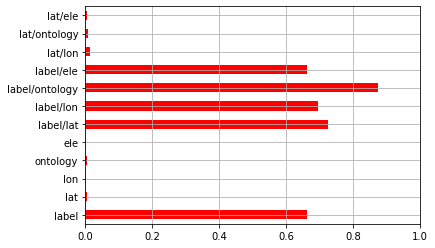

In [26]:
negrank_deeper[0:12].plot.barh(color='red',grid=True,xlim=(0,1))

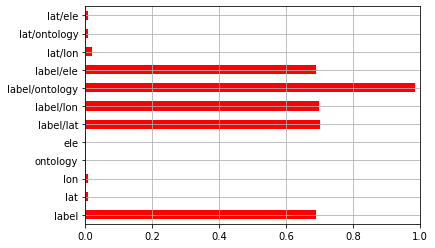

In [29]:
negrank_deepmatcher[0:12].plot.barh(color='red',grid=True,xlim=(0,1))

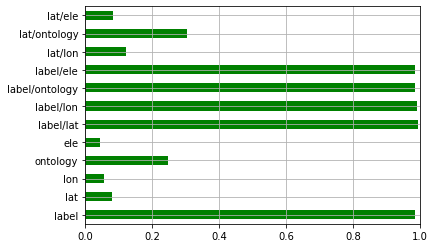

In [28]:
posrank_deeper[0:12].plot.barh(color='green',grid=True,xlim=(0,1))

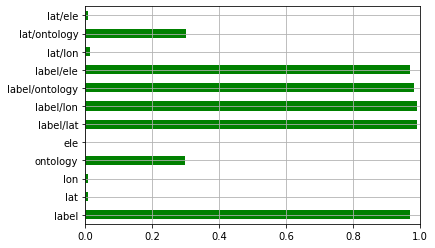

In [30]:
posrank_deepmatcher[0:12].plot.barh(color='green',grid=True,xlim=(0,1))

In [31]:
saveExplanationResult('rankings/','deeper','geography',posrank_deeper,negrank_deeper,flippedpos_deeper,
                     flippedneg_deeper)

In [32]:
saveExplanationResult('rankings/','deepmatcher','geography',posrank_deepmatcher,negrank_deepmatcher,flippedpos_deepmatcher,
                     flippedneg_deepmatcher)

In [34]:
flippedpos_deepmatcher['alteredAttributes'].value_counts()

(label, lat, lon)         520
(label, lat, ele)         518
(label, lat, ontology)    518
(label, lon, ontology)    518
(label, lat)              518
(label, lon, ele)         517
(label, lon)              517
(label, ontology)         512
(label, ontology, ele)    512
(label,)                  506
(label, ele)              506
(lat, lon, ontology)      162
(lat, ontology, ele)      157
(lat, ontology)           157
(lon, ontology, ele)      156
(lon, ontology)           156
(ontology, ele)           155
(ontology,)               155
(lat, lon)                  8
(lat, lon, ele)             8
(lon, ele)                  4
(lat,)                      4
(lat, ele)                  4
(lon,)                      4
Name: alteredAttributes, dtype: int64